In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as p
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.spatial import distance
from scipy.stats.mstats import gmean
from sklearn.linear_model import LinearRegression
%matplotlib inline
from itertools import combinations
from itertools import chain
import sys
import os
import copy
sns.set_style('white')
sns.set_style('ticks')
sns.set_color_codes()

fgm_simulation_path = '/Users/grantkinsler/Documents/Stanford/Research/StarryNight/Git/starry-night/Simulations/FGM_simulation_callable.py'
sys.path.append(os.path.dirname(os.path.expanduser(fgm_simulation_path)))
from FGM_simulation_callable import simulation, nball_pull, gaussian_fitness

tools_path = '../code/tools.py'
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools
from tools import mutant_colorset
from tools import condition_colorset

In [2]:
cov_thresh = 1e6
fitness_data = p.read_csv('../data/fitnesses_merged_NoWeight_plusflat_resample1000000.csv')

In [3]:
mutant_train_set = p.read_csv('../data/mutant_train_set.csv')
training_bcs = mutant_train_set['barcode'].values

In [4]:
old_conditions = {
                  '3':['3.1','3.2','3.3'],
                  '6':['6.1','6.2','6.3'],
                  '13':['13.1','13.2','13.3'],
                  '18':['18.1','18.2','18.3'],
                  '20':['20.1','20.2','20.3'],
                  '21':['21.1','21.2','21.3'],
                  '23':['23.1','23.2','23.3']
                 }

bigbatch_conditions = {
                        '1BB_M3':['A','B','C','D'],
                        '1BB_Baffle':['E','F'],
                        '1BB_1.4%Gluc' :['G','H'],
                        '1BB_1.8%Gluc' :['I','J'],
#                         '1BB_0.2MNaCl' :['K','L'],
#                         '1BB_0.2MKCl' :['O'],
#                         '1BB_0.5MKCl' :['P'],
#                         '1BB_8.5uMGdA' :['Q','R'],
#                         '1BB_17uMGdA' :['S','T'],
#                         '1BB_2ugFlu' :['U','V'],
#                         '1BB_0.5ugFlu' :['W','X'],
                        '1BB_1%Raf' :['Y','Z'],
                        '1BB_0.5%Raf' :['AA','BB'],
                        '1BB_1%Gly' :['CC','DD'],
#                         '1BB_1%EtOH' :['EE','FF'],
#                         '1BB_SucRaf' :['GG'],
                      }


# m3_conditions = {**old_conditions,}
conditions = {**old_conditions, **bigbatch_conditions}
all_conditions = conditions.keys()
all_reps = [rep for reps in conditions.values() for rep in reps]

m3_conditions = list(old_conditions.keys()) + ['1BB_M3']
m3_reps = [rep for condition in m3_conditions for rep in conditions[condition]]



In [5]:
this_data = fitness_data
this_data = this_data.replace([np.inf, -np.inf], np.nan)
this_data = this_data.dropna('columns',how='all')
this_data = this_data.dropna()

this_data = this_data.sort_values('barcode')

fitness_cols = [col for col in this_data.columns if '_fitness' in col]

fitness = this_data[fitness_cols].values

n_mutants = fitness.shape[0]
n_conditions = fitness.shape[1]




In [6]:
this_data = fitness_data
this_data = this_data.replace([np.inf, -np.inf], np.nan)
this_data = this_data.dropna('columns',how='all')
this_data = this_data.dropna()

this_data = this_data.sort_values('barcode')

fitness_cols = [col for col in this_data.columns if '_fitness' in col if 'original' in col if '_T' not in col if 'PCR' not in col]

fitness = this_data[fitness_cols].values

n_mutants = fitness.shape[0]
n_conditions = fitness.shape[1]

train_cols = [col+'_original_fitness' for col in [col.split('_')[0] for col in fitness_cols] if col in m3_reps]
test_cols =  [col+'_original_fitness'  for col in [col.split('_')[0] for col in fitness_cols] if col not in m3_reps]



AA
BB
CC
E
F
G
H
I
J
Y
Z


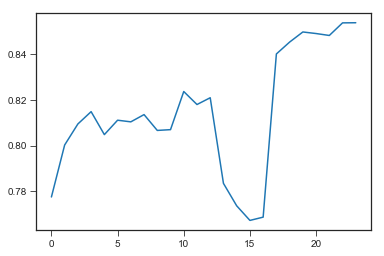

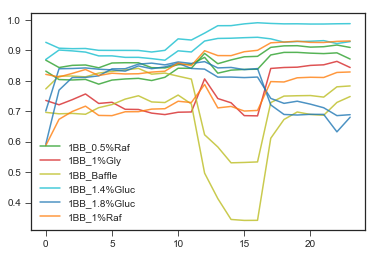

In [7]:

train_conditions = train_cols
train_locs = np.where(np.isin(fitness_cols,train_conditions))[0]

test_conditions = test_cols
test_conditions = [rep for rep in  test_conditions if rep.split('_')[0] in all_reps]
test_locs = np.where(np.isin(fitness_cols,test_conditions))[0]


all_locs = sorted(list(train_locs)+list(test_locs))

this_fitness = fitness[:,all_locs]
new_train_locs = np.where(np.isin(all_locs,train_locs))[0]
new_test_locs = np.where(np.isin(all_locs,test_locs))[0]

train = [new_train_locs,np.where(np.isin(this_data['barcode'].values,training_bcs))[0]]
test = [new_test_locs,np.where(~np.isin(this_data['barcode'].values,training_bcs))[0]]


by_rank, by_condition, by_mutant, mean_fits = tools.SVD_predictions_train_test(this_fitness,train,test,by_condition=True,by_mutant=False)
by_condition = np.asarray(by_condition).swapaxes(0,1)

condition_colors = sns.color_palette()
plt.plot(by_rank)
plt.figure()
start = 0
already_plotted = []



for k,condition in enumerate(test_conditions):
    condition = condition.split('_')[0]
    print(condition)
    condition_name = [name for name, reps in conditions.items() for rep in reps if rep == condition][0]
    index = np.where(np.asarray(list(conditions.keys()))==condition_name)[0][0]
    
    index =  index % len(condition_colors)
    if condition_name not in already_plotted:
        plt.plot(by_condition[k],label=condition_name,color=condition_colors[index],alpha=0.8)
        already_plotted.append(condition_name)
    else:
        plt.plot(by_condition[k],color=condition_colors[index],alpha=0.8)
plt.legend()

In [8]:
from multiprocessing import Pool

In [12]:
p = Pool(10)
entries = [[this_fitness,train,test,n_components] for n_components in range(1,25)]
# (,by_condition=True,by_mutant=False)
output = p.starmap(tools.SVD_predictions_train_test_mixnmatch,entries)

KeyboardInterrupt: 

Process ForkPoolWorker-39:
Process ForkPoolWorker-35:
Process ForkPoolWorker-38:
Process ForkPoolWorker-40:
Process ForkPoolWorker-32:
Process ForkPoolWorker-37:
Process ForkPoolWorker-34:
Process ForkPoolWorker-33:
Process ForkPoolWorker-36:
Process ForkPoolWorker-31:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framewo

  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/linalg/linalg.py", line 1724, in pinv
    u, s, vt = svd(a, full_matrices=False)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/linalg/linalg.py", line 1444, in svd
    u, s, vh = gufunc(a, signature=signature, extobj=extobj)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/linalg/linalg.py", line 1444, in svd
    u, s, vh = gufunc(a, signature=signature, extobj=extobj)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/linalg/linalg.py", line 1444, in svd
    u, s, vh = gufunc(a, signature=signature, extobj=extobj)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/linalg

In [36]:
%%time
if __name__ ==  '__main__': 
    p = Pool(10)
    entries = [[this_fitness,train,test,n_components,False,False] for n_components in range(1,25)]
    # (,by_condition=True,by_mutant=False)
    output = p.starmap(tools.SVD_predictions_train_test_mixnmatch,entries)

CPU times: user 1min 36s, sys: 1min 20s, total: 2min 56s
Wall time: 1h 13min 51s


In [50]:
output[0][0]

[0.7775464290186149,
 -1.7462627649199987,
 -1.7322641952199276,
 -1.8075848574009248,
 -1.8071511589631837,
 -1.8039558786969931,
 -1.8103381478808624,
 -1.8074569334136434,
 -1.7884100100802862,
 -1.794749121032754,
 -1.8362844687658728,
 -1.8034855936533494,
 -1.893842230766019,
 -1.8112373698713573,
 -1.816097188453781,
 -1.8124588165782156,
 -1.8164305059075976,
 -1.8163543693231108,
 -1.8102422591361833,
 -1.796341314905836,
 -1.8078083617314307,
 -1.804494066515543,
 -1.8175237432201117,
 -1.794151939431321]

In [54]:
sort_list = []
for o in output:
    sort_list.append(sorted([(o1,o2) for o1,o2 in zip(o[0],o[4])],reverse=True))
    

In [55]:
sorted_rank_combos = sort_list

RuntimeError: Failed to open TrueType font

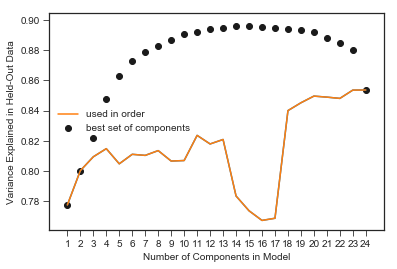

In [57]:
by_rank, by_condition, by_mutant, mean_fits = tools.SVD_predictions_train_test(this_fitness,train,test,by_condition=True,by_mutant=False)
# by_condition = np.asarray(by_condition).swapaxes(0,1)

condition_colors = sns.color_palette()
plt.plot(by_rank)

for rank in range(len(sorted_rank_combos)):
    plt.scatter(rank,sorted_rank_combos[rank][0][0],color='k',label='best set of components' if rank ==0 else '_nolegend_')
plt.plot(by_rank,label='used in order')
# plt.savefig('predictions_best_per_rank.pdf',bbox_inches='tight')
plt.xticks(range(len(by_rank)),range(1,len(by_rank)+1))
plt.xlabel('Number of Components in Model')
plt.ylabel('Variance Explained in Held-Out Data')
plt.legend()
plt.savefig('best_set_vs_in_order_all.pdf',bbox_inches='tight')

In [31]:
%%time
o = []
for n_components in range(1,5):
    by_rank, by_condition, by_mutant, mean_fits, component_sets = tools.SVD_predictions_train_test_mixnmatch(this_fitness,train,test,n_components,by_condition=True,by_mutant=False)
    o.append(sorted([(rank,combo) for rank,combo in zip(by_rank,component_sets)],reverse=True))



CPU times: user 15.1 s, sys: 470 ms, total: 15.6 s
Wall time: 34.6 s


In [63]:
sorted_rank_combos[6]

[(0.8785819075879436, [0, 1, 2, 9, 10, 12, 17]),
 (0.8770446318593077, [0, 1, 2, 7, 10, 12, 17]),
 (0.8763761257533184, [0, 1, 2, 3, 10, 12, 17]),
 (0.876272100070757, [0, 1, 2, 5, 10, 12, 17]),
 (0.8752940410415991, [0, 1, 2, 10, 12, 17, 19]),
 (0.8739377955644658, [0, 1, 2, 10, 12, 16, 17]),
 (0.8737460397343314, [0, 1, 2, 6, 10, 12, 17]),
 (0.873565355369854, [0, 1, 2, 10, 11, 12, 17]),
 (0.87297186151656, [0, 1, 2, 3, 8, 10, 17]),
 (0.8727238941920381, [0, 1, 2, 10, 12, 17, 23]),
 (0.8723689696864775, [0, 1, 2, 10, 12, 17, 21]),
 (0.8722390689577192, [0, 1, 2, 10, 12, 17, 20]),
 (0.8714454687763196, [0, 1, 2, 7, 8, 10, 17]),
 (0.8713969764924173, [0, 1, 2, 8, 10, 17, 19]),
 (0.8708718512808002, [0, 1, 2, 10, 12, 17, 18]),
 (0.8708306655632606, [0, 1, 2, 5, 8, 10, 17]),
 (0.8707817426646477, [0, 1, 2, 8, 10, 14, 17]),
 (0.8707719842860515, [0, 1, 2, 3, 5, 10, 17]),
 (0.8704256336135026, [0, 1, 2, 8, 10, 16, 17]),
 (0.870276423848967, [0, 1, 2, 3, 7, 10, 17]),
 (0.8699833141457991, [